In [2]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

import os
import timeit
from datetime import datetime
from mpf_utils import load_data


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

In [3]:
def initalizeParameters(units = 32):
    """
    Initialize an initial symmetric W matrix from a random normal distribution with mean 0 and variance 1/n.
    Inputs:
    - n: size of the Boltzmann Machine (BM).
    """
    U = np.random.normal(loc = 0, scale = 1/units, size = (units, units))
    return 0.5 * (U + U.T)

Problem encountered here: the Kcost function to compute the function is done in numpy, but if we are going to use Theano to do stochastic gradient descent, we have to use the tensors. But using tensors, we are not able to get the shape of our samples which complicate things. An attempt to manually give the size of samples and number of units lead to values of the bias very close to 0, which for now I have no idea why this is happening although my gradient checking shows that everything should be correct.

Things to resolve:
- how to use Theano to do stochastic gradient descent with my own gradient
- why is the bias value learnt so close to 0, could it be some error lying somewhere that contribute to this deviation towards 0?

In [4]:
def Kcost(x, W, temperature = 1):

    """
    Returns the cost computed by using the diagonals as the bias.
    Inputs:
    - x: samples used to train W.
    - W: weights between the neurons of the Boltzmann Machine (BM).
    - n: number of neurons in the BM.
    - temperature: keep it as 1 until cost grows too big then raise temperature.
    """
    num_samples = 50000 #x.shape[0]        
    num_units = 16 #x.shape[1]
    delta = 1/2 - x
    diag = np.diag(W)[:, None].T
    E = delta * np.dot(x, W) - .25 * diag

    cost = np.sum(np.exp(1/temperature * E)) / num_samples         
    k = np.exp(E)        
    D = np.dot((delta * k).T, x)         
    C = np.zeros((num_units,))         
    np.copyto(C, np.diag(D))                 
    np.fill_diagonal(D, 0)         
    C = C - .25 * np.sum(k, axis = 0)         
    D = D + D.T         
    np.fill_diagonal(D, C) 

    return cost, D/ num_samples

In [8]:
class mpf(object):
    """
    Minimum probability flow with bias in the diagonals
    """
    
    def __init__(self, input = None, n = 32, temperature = 1,  W = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)


        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

        self.W = W
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W]
        
    def Kcost(self, lr = 1e-2):
        """
        Returns the cost computed by using the diagonals as the bias.
        Inputs:
        - x: samples used to train W.
        - W: weights between the neurons of the Boltzmann Machine (BM).
        - n: number of neurons in the BM.
        - temperature: keep it as 1 until cost grows too big then raise temperature.
        """
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print (str(datetime.now()))
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))

        num_samples = 50000 #self.x.shape[0]        
        num_units = 16 #self.x.shape[1]
        delta = 1/2 - self.x
        diag = T.diag(self.W)[:, None].T
        E = delta * T.dot(self.x, self.W) - .25 * diag
        
        cost = T.sum(T.exp(1/self.temperature * E)) / num_samples         
        k = T.exp(E)        
        D = T.dot((delta * k).T, self.x)  
        C = T.diag(D)
        C = T.nlinalg.AllocDiag()(C)
#         C = T.zeros((num_units,))         
#         T.copyto(C, T.diag(D))                 
        D = T.fill_diagonal(D, 0)         
        C = C - .25 * T.sum(k, axis = 0)         
        D = D + D.T + C         
#         T.fill_diagonal(D, C) 
        
        Wupdate = self.W - lr * (D/num_samples)
        
        updates = [(self.W, Wupdate)]

        return cost, updates

In [6]:
def trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.Kcost(lr = lr)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
    best_b = [None, np.inf]
    best_epoch = np.inf
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        b_learnt = np.zeros((units,))
        np.copyto(b_learnt, np.diag(W_learnt))                        
        np.fill_diagonal(W_learnt, 0)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
                            
        mseW = np.linalg.norm(W - (W_learnt))/ (units**2)
        mseb = np.linalg.norm(b - b_learnt)/ units
        mse = mseW + mseb

        if mse < best_mse:
            best_mse = mse
            best_W[0] = W_learnt  
            best_W[1] = mseW
            best_b[0] = b_learnt  
            best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print (b_learnt)
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f, Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse,  (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,10))
#     fig, ax = plt.subplots(figsize=(20,10))
    fig.tight_layout()
    plt.setp(ax, xticks=np.arange(0,100,16))

#     plt.xticks(np.arange(0,100,16))
    
#     ax.plot(W.reshape(-1,1)[0:100], 'r')
#     ax.plot((-W_learnt).reshape(-1,1)[0:100], 'b')
#     ax.plot(-best_W[0].reshape(-1,1)[0:100], 'g')
#     ax.set_title('W')
#     ax.legend(['W', 'Learnt W','Best W'])
    ax[0,0].plot(W.reshape(-1,1)[0:100], 'r')
    ax[0,0].plot(W_learnt.reshape(-1,1)[0:100], 'b')
    ax[0,0].plot(best_W[0].reshape(-1,1)[0:100], 'g')
    ax[0,0].set_title('W')
    ax[0,0].legend(['W', 'Learnt W','Best W'])
    ax[0,1].plot(W.reshape(-1,1)[101:200], 'r')
    ax[0,1].plot(W_learnt.reshape(-1,1)[101:200], 'b')
    ax[0,1].plot(best_W[0].reshape(-1,1)[101:200], 'g')
    ax[0,1].set_title('W')
    ax[0,1].legend(['W', 'Learnt W','Best W'])
    ax[1,0].plot(W.reshape(-1,1)[201:256], 'r')
    ax[1,0].plot(W_learnt.reshape(-1,1)[201:256], 'b')
    ax[1,0].plot(best_W[0].reshape(-1,1)[201:256], 'g')
    ax[1,0].set_title('W')
    ax[1,0].legend(['W', 'Learnt W','Best W'])
    ax[1,1].plot(b.reshape(-1,1), 'r')
    ax[1,1].plot(b_learnt.reshape(-1,1),'b')
    ax[1,1].plot(best_b[0].reshape(-1,1),'g')
    ax[1,1].set_title('b')
    ax[1,1].legend(['b', 'Learnt b','Best b'])

    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
    print ('Best mse: {0}'.format(best_mse))
    print ('Best W mse: {0}'.format(best_W[1]))
    print ('Best b mse: {0}'.format(best_b[1]))
    print ('Best epoch: {0}'.format(best_epoch))
    print ('=' * 51)

########################MPF########################
2017-06-02 10:45:08.123270
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy
[ 0.07209565  0.15172297  0.44690807  0.53689387  0.19859039  0.28733548
  0.7761855   0.18572275  0.52704141  0.3059945   0.04581869  0.66545279
  0.423533    0.55111949  0.64049392  0.16164796]
Training epoch 0/1000, Cost: 0.019301 mseW: 0.05457, mseb: 0.32156, mse: 0.37613, Time Elasped: 0.00 
[ 0.00346447  0.00342349  0.00392349  0.00451636  0.00437451  0.00317821
  0.00412772  0.0042249   0.00316659  0.00464762  0.00406688  0.0046766
  0.00321966  0.00440118  0.00390913  0.00454911]
Training epoch 100/1000, Cost: 0.005878 mseW: 0.04426, mseb: 0.27627, mse: 0.32053, Time Elasped: 0.37 
[ 0.00339875  0.00349031  0.00392066  0.00367558  0.00385621  0.00306955
  0.00262096  0.00417564  0.00327699  0.00386118  0.00405867  0.00413464
  0.00317518  0.00388498  0.00387728  0.00392066]
Training epoch 200/1000, Cost: 0.005005 mseW:

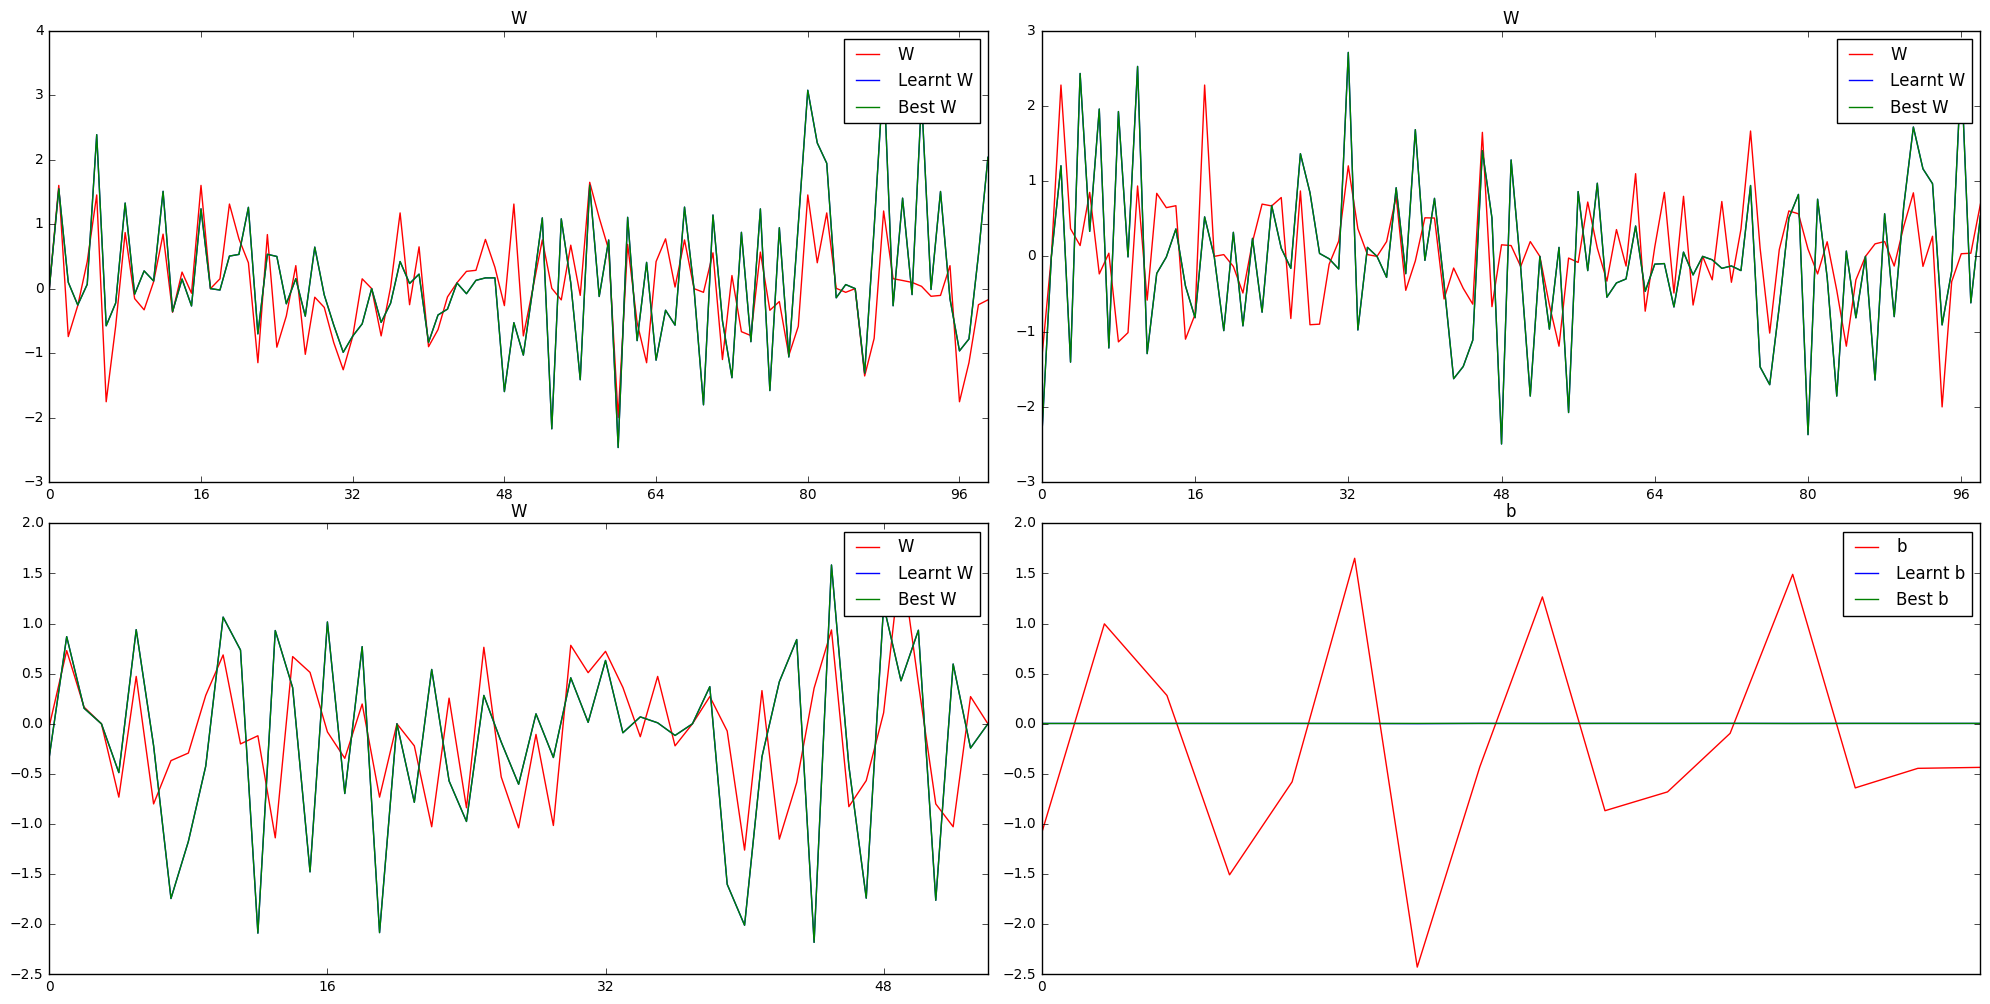

In [9]:
trainmpf(units = 16, lr = 1e-2, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

In [ ]:
b = np.load('16-b.npy')
print (b)